This notebook shows a short demonstration of using data from HIP partners to do simulation, with parameters guessed from one of the patient's seizures.

In [5]:
%pylab inline
import re
import numpy as np
import mne
import nibabel
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib


Load our electrode position annotations, which I marked by hand (I was not able to figure out the translation from provided coordinates to the FreeSurfer T1 reference frame),

In [6]:
pl_names = []
pl_xyz = []
with open('pos-t1.txt', 'r') as fd:
    for line in fd.readlines():
        if line.startswith('plot'):
            continue
        name, *xyz = line.strip().split(' ')
        pl_names.append(name)
        pl_xyz.append(np.array([float(_) for _ in xyz]))

def cxyz(pl, idx, contact_dist=3.5):
    target, entry = pl_xyz[pl_names.index(pl)].reshape((2, 3))
    axis = entry - target
    unit = axis / np.linalg.norm(axis)
    return target + contact_dist * (idx - 1) * unit

# TODO QC figure to check positions
# t1 = nibabel.load('/Users/duke/data/fs/chuv/mri/T1.mgz')
# imshow(t1.get_fdata()[128], cmap='gray')

Load connectivity & one seizure,

WARNING  File 'hemispheres' not found in ZIP.


(Text(0.5, 0, 'ROI (DK atlas)'), Text(0, 0.5, 'ROI'))

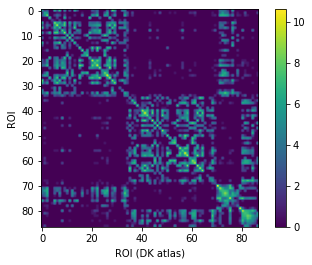

In [8]:
conn = connectivity.Connectivity.from_file('/home/duke/data/chuv/tvb/connectivity.zip')
conn.weights[:] = np.log(1 + conn.weights)
imshow(conn.weights); colorbar(); xlabel('ROI (DK atlas)'), ylabel('ROI')

In [9]:
raw = mne.io.read_raw_brainvision('/home/duke/data/chuv/seeg/12.vhdr')

Extracting parameters from /home/duke/data/chuv/seeg/12.vhdr...
Setting channel info structure...


Construct gain matrix for bipolar electrodes in recording,

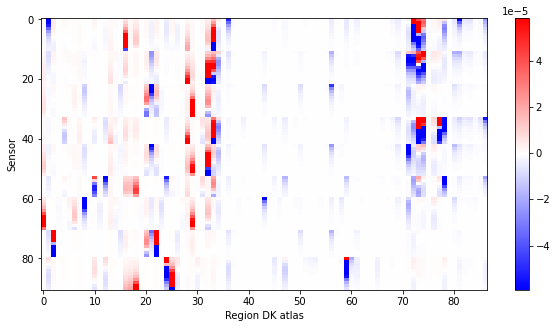

In [10]:
re_one = '([A-Z][A-Za-z]*\'?) ([0-9]+)'
re_bip = re.compile(f'{re_one}-{re_one}')
ch_bip_idx = []
bip_gain = []
electrodes = []
picks = []
pick_names = []
for i_ch, ch in enumerate(raw.ch_names):
    match = re_bip.match(ch)
    if match:
        picks.append(i_ch)
        pick_names.append(ch)
        e, i, _, j = match.groups()
        electrodes.append(e)
        i, j = int(i), int(j)
        e = e.replace('\'', 'p')
        ch_bip_idx.append((e, i, j))
        r = np.sqrt(np.sum((cxyz(e,np.c_[i,j].T)[:,None] - conn.centres)**2, axis=2))
        g = 1/r**3
        bip_gain.append(g[1] - g[0])
picks = np.array(picks)
bip_gain = np.array(bip_gain)
bip_gain = np.clip(bip_gain, *np.percentile(bip_gain.flat[:], [1,99]))
figure(figsize=(10, 5))
imshow(bip_gain, cmap='bwr', aspect='auto', interpolation='none'), colorbar(), xlabel('Region DK atlas'), ylabel('Sensor');

Pick out seizure from recording,

Reading 0 ... 12800  =      0.000 ...   100.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 sec)

Using matplotlib as 2D backend.


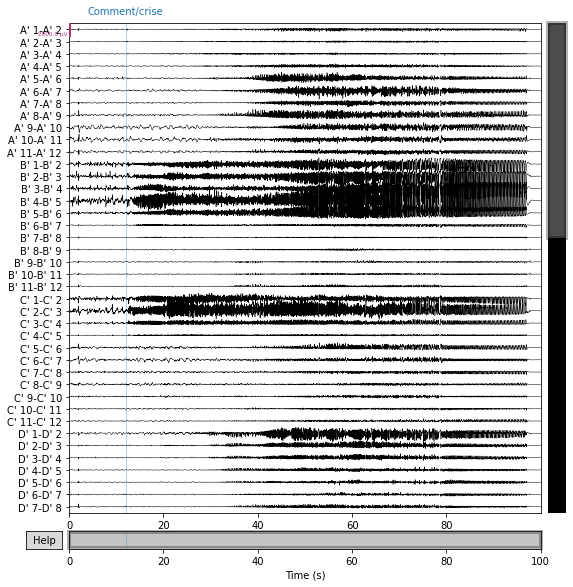

In [11]:
snip = raw.copy().crop(2170,2270)
snip.pick_channels(pick_names)
snip.load_data()
snip.filter(1,30)
snip.resample(64)
snip.plot(n_channels=40,duration=100,scalings={'eeg':1e-3});

We construct the envelop of the data, per 1 s windows,

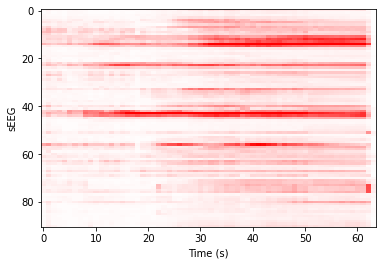

In [12]:
y, t = snip[:]
ysd = y.reshape((91, 64, 100)).std(axis=-1)
scl = 1e-3
imshow(ysd, aspect='auto', interpolation='none', cmap='bwr', vmin=-scl, vmax=scl)
xlabel('Time (s)'), ylabel('sEEG');

Projecting to TVB sources, we can determine a prior for the Epileptor x0 parameter based onset times,

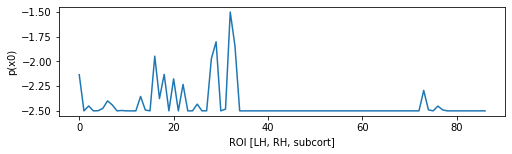

In [13]:
ssd = np.clip(bip_gain.T.dot(ysd),0,1) * np.r_[1:0:64j]**3
x0p = ssd.sum(axis=-1)
x0p /= x0p.max()
x0p = -2.5 + x0p
figure(figsize=(8, 2)); plot(x0p); xlabel('ROI [LH, RH, subcort]'); ylabel('p(x0)');

With a few examples for the ranking

In [14]:
for i in np.argsort(x0p)[::-1][:5]:
    print(i, x0p[i], conn.region_labels[i])

32 -1.5 ctx-lh-transversetemporal
29 -1.8014242042331023 ctx-lh-supramarginal
33 -1.8432334530272518 ctx-lh-insula
16 -1.9468262371016705 ctx-lh-parsopercularis
28 -1.9720949784904642 ctx-lh-superiortemporal


Now construct a simulation,

In [15]:
epileptor = models.Epileptor(Ks=np.r_[-0.2], Kf=np.r_[0.1], r=np.r_[0.00015])
epileptor.x0 = x0p
nsig = np.r_[0., 0., 0., 0.0005, 0.0005, 0.]
addnoise = noise.Additive(nsig=nsig, ntau=5.0)
initial = np.r_[-1.9, -17., 3.1, -1., 0.04, -0.17]
initial = np.zeros((100, 1, 87, 1)) + initial[:, None, None]
sim = simulator.Simulator(
    connectivity=conn,
    coupling=coupling.Difference(a=np.r_[0.03]),
    model=epileptor,
    integrator=integrators.HeunStochastic(dt=0.05,noise=addnoise),
    initial_conditions=initial,
)
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 52a49592-7f37-49d5-9fd1-5326665ce737
coupling,Difference gid: 89b2a0d7-c96a-4021-93e0-093eefd92c45
gid,UUID('9799ae97-5f72-4fb0-9319-c22a9fe24172')
"initial_conditions [min, median, max]","[-17, -0.585, 3.1]"
initial_conditions dtype,float64
initial_conditions shape,"(100, 6, 87, 1)"
integrator,HeunStochastic gid: 6c91f710-d417-4549-bdb4-21b737a94250
model,Epileptor gid: 9bffac52-37df-4d50-8a1d-ca8179fd1fb6


In [16]:
(t,y), = sim.run(simulation_length=4000.0)

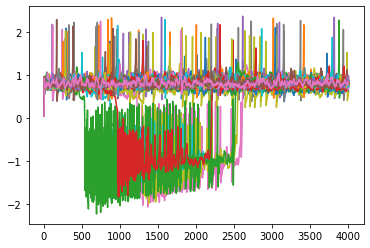

In [17]:
plot(t,y[:,0,:,0]);

In [18]:
seeg = bip_gain.dot(y[:,0,:,0].T)
seeg /= seeg.std()
seeg *= snip[:][0].std()
info = mne.create_info(pick_names, 1e3/(t[1] - t[0])/8, 'eeg')
raw_sim = mne.io.RawArray(seeg, info)
raw_sim.info['sfreq']

Creating RawArray with float64 data, n_channels=91, n_times=4000
    Range : 0 ... 3999 =      0.000 ...    31.992 secs
Ready.


125.0

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 413 samples (3.304 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  91 out of  91 | elapsed:    0.8s finished


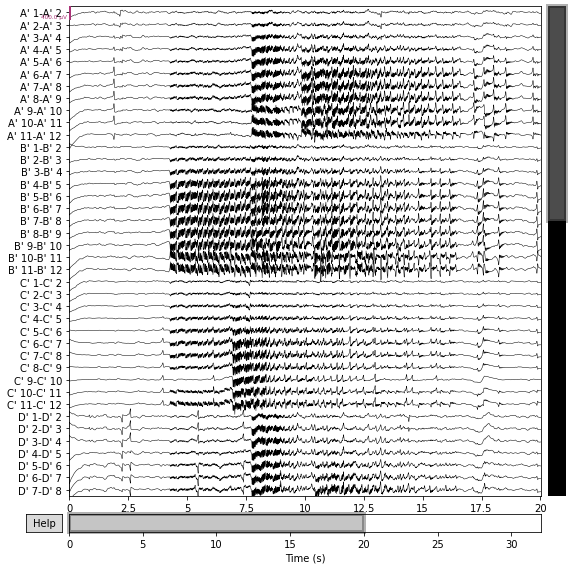

In [19]:
raw_sim.filter(1,50,n_jobs=4)
raw_sim.plot(n_channels=40,duration=20,scalings={'eeg':2e-4});

That's not quite as specific as I'd like.   Bipolar should be a little more precise, but this is likely a limit of using the default FS parcellation.  Reprocessing the diffusion data should allow for better precision.

We can have a look at the source time series, along with the closest sensor trace,

In [20]:
np.argmax(bip_gain[:,32])

15

In [21]:
specgram

<function matplotlib.pyplot.specgram(x, NFFT=None, Fs=None, Fc=None, detrend=None, window=None, noverlap=None, cmap=None, xextent=None, pad_to=None, sides=None, scale_by_freq=None, mode=None, scale=None, vmin=None, vmax=None, *, data=None, **kwargs)>

Text(0.5, 1.0, "B' 5-B' 6")

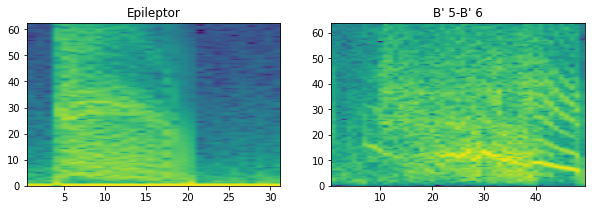

In [22]:
imax = np.argmax(y[:,0,:,0].std(axis=0))
figure(figsize=(10, 3))
subplot(121); specgram(y[:, 0, imax, 0],256,1e3/(t[1] - t[0])/8); title('Epileptor')
imax_ch = np.argmax(bip_gain[:,32])
subplot(122); specgram(snip[:][0][imax_ch],256,128); title(pick_names[imax_ch])

The bifurcation types in the data are different than the default in the Epileptor, which is something that can be tuned further afterwards.  Specifically, tuning the codim3 burster + AR noise process.